In [1]:
import caffe

In [2]:
pwd

u'/data/convchess/src/play/example_moves'

In [71]:
cd /data/convchess/src/play/example_moves/

/data/convchess/src/play/example_moves


In [4]:
cd ..

/data/convchess/src/play


In [5]:
ls

example_moves/  play4.py                 sunfish_mod2.py   sunfish.pyc
__init__.py     play4.pyc                sunfish_mod2.pyc  sync_models.sh*
__init__.pyc    play_against_sunfish.py  sunfish_mod3.py   td_evaluate.py
models/         play.py                  sunfish_mod3.pyc  td_evaluate.pyc
play2.py        play.pyc                 sunfish_mod4.py   util.py
play2.pyc       regression_models@       sunfish_mod.py    util.pyc
play3.py        stats.txt                sunfish_mod.pyc   win.txt
play3.pyc       sunfish/                 sunfish.py


In [6]:
from play4 import *

In [6]:
trained_models

{'B': <caffe._caffe.Net at 0x7f948b901b50>,
 'K': <caffe._caffe.Net at 0x7f948b901c00>,
 'N': <caffe._caffe.Net at 0x7f948b901af8>,
 'P': <caffe._caffe.Net at 0x7f948b901a48>,
 'Piece': <caffe._caffe.Net at 0x7f948b901680>,
 'Q': <caffe._caffe.Net at 0x7f948b901ba8>,
 'R': <caffe._caffe.Net at 0x7f948b901aa0>}

In [7]:
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
print pos.board
bb = pos_board_to_bitboard(pos.board)
print bb
#since the models have an elo layer for a 12 channel style, we will add that too.
im = convert_bitboard_to_image_2(bb)
im = np.rollaxis(im ,2 , 0)
im = np.append(im, elo_layer, axis=0)
print im

         
         
 rnbqkbnr
 pppppppp
 ........
 ........
 ........
 ........
 PPPPPPPP
 RNBQKBNR
         
          
r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  

In [8]:
get_top_moves(im, 10)

[('e2e4', 0.60884749889373779),
 ('d2d4', 0.24676373600959778),
 ('c2c4', 0.072589606046676636),
 ('g1f3', 0.03345726802945137),
 ('e2e3', 0.017165167257189751),
 ('f2f4', 0.005938130896538496),
 ('g2g3', 0.0052636517211794853),
 ('b1c3', 0.0021147150546312332),
 ('b2b3', 0.0013837352162227035),
 ('c2c3', 0.0013727180194109678)]

In [9]:
dummy = np.ones((1,), dtype=np.float32)
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype='float32'),dummy)
res = net.forward()
probs = res['prob']
matrix= probs.reshape((8,8))
#matrix = (matrix+matrix[:,::-1])/2.0

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def matrixplot(c_matrix):
    plt.imshow(c_matrix, interpolation='nearest', cmap=cm.Greys ,
        extent=(0.5,np.shape(matrix)[0]+0.5,0.5,np.shape(matrix)[1]+0.5))
    plt.colorbar()
    plt.show()

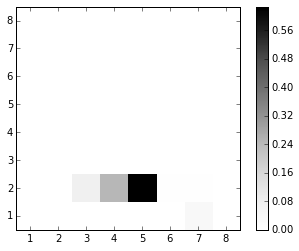

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matrixplot(matrix)

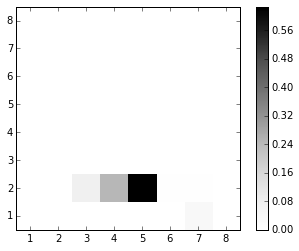

In [12]:
c_probs = clip_pieces_single_2(probs, im[0:12])
c_matrix = c_probs.reshape((8,8))
#c_matrix = (c_matrix+c_matrix[:,::-1])/2.0
matrixplot(c_matrix)

In [13]:
dummy = np.ones((1,), dtype='float32')
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype=np.float32),dummy)
res = net.forward()
probs = res['prob']
#probs = clip_pieces_single_2(probs, im[0:12])
#print probs
probs = probs.flatten()
cumulative_probs = np.zeros((64,64))    
for i, piece_pos in enumerate(topk(probs,10)):
    if probs[piece_pos]>0:
        i1,i2 = scoreToCoordinateIndex(piece_pos)
        pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
        piece_layer = np.zeros((1,8,8))
        piece_layer[0,i1,i2] = 1
        img2 = np.append(im, piece_layer, axis=0)
        model = trained_models[pieceType]
        model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
        res2 = model.forward()
        move_prob = res2['prob']
        #print move_prob
        #move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
        #print move_prob
        cumulative_probs[piece_pos] = move_prob*probs[piece_pos]

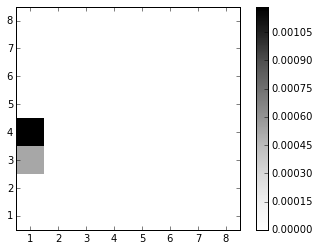

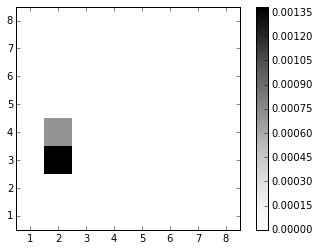

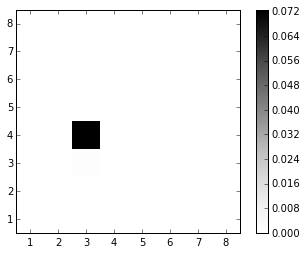

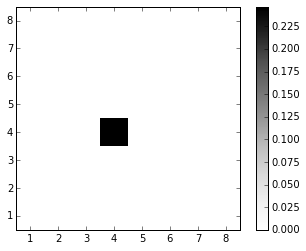

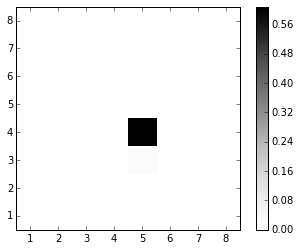

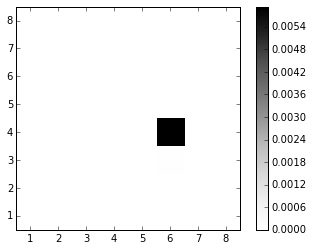

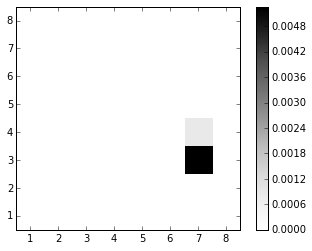

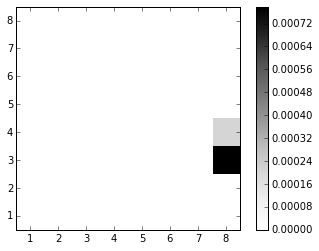

In [14]:
matrixplot(cumulative_probs[48].reshape((8,8)))
matrixplot(cumulative_probs[49].reshape((8,8)))
matrixplot(cumulative_probs[50].reshape((8,8)))
matrixplot(cumulative_probs[51].reshape((8,8)))
matrixplot(cumulative_probs[52].reshape((8,8)))
matrixplot(cumulative_probs[53].reshape((8,8)))
matrixplot(cumulative_probs[54].reshape((8,8)))
matrixplot(cumulative_probs[55].reshape((8,8)))

In [20]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


In [21]:
import numpy as np
import cv2
pieces = ['pawn', 'rook', 'knight', 'bishop', 'queen', 'king']

def blank_board(img_size):
	board = np.zeros((img_size, img_size), dtype=np.uint8)
	piece_size = img_size/8
	for i in xrange(8):
		for j in xrange(8):
			if (i+j)%2 == 0:
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = 255*np.ones((piece_size, piece_size), dtype=np.uint8)
	return board

def draw_board(bitmap, img_size=344, highlight=None):
	piece_size = img_size/8

	#initialize blank board
	board = blank_board(img_size)
	bw = cv2.CV_LOAD_IMAGE_GRAYSCALE
	#load piece images
	wpawnw = cv2.imread("elements/wpawnw.png", bw)
	wpawnb = cv2.imread("elements/wpawnb.png", bw)
	bpawnw = abs(255-wpawnb)
	bpawnb = abs(255-wpawnw)
	wrookw = cv2.imread("elements/wrookw.png", bw)
	wrookb = cv2.imread("elements/wrookb.png", bw)
	brookw = abs(255-wrookb)
	brookb = abs(255-wrookw)
	wknightw = cv2.imread("elements/wknightw.png", bw)
	wknightb = cv2.imread("elements/wknightb.png", bw)
	bknightw = abs(255-wknightb)
	bknightb = abs(255-wknightw)
	wbishopw = cv2.imread("elements/wbishopw.png", bw)
	wbishopb = cv2.imread("elements/wbishopb.png", bw)
	bbishopw = abs(255-wbishopb)
	bbishopb = abs(255-wbishopw)
	wqueenw = cv2.imread("elements/wqueenw.png", bw)
	wqueenb = cv2.imread("elements/wqueenb.png", bw)
	bqueenw = abs(255-wqueenb)
	bqueenb = abs(255-wqueenw)
	wkingw = cv2.imread("elements/wkingw.png", bw)
	wkingb = cv2.imread("elements/wkingb.png", bw)
	bkingw = abs(255-wkingb)
	bkingb = abs(255-wkingw)

	for p in xrange(bitmap.shape[0]-1):
		for i in xrange(bitmap.shape[1]):
			for j in xrange(bitmap.shape[2]):
				if p%2==0 and bitmap[p,i,j] == 1:
					piece = "w"
				elif p%2==1 and bitmap[p,i,j] == 1:
					piece = "b"
				else:
					continue
				piece = piece+pieces[p/2]
				if (i+j)%2 == 0:
					piece = piece+"w"
				else:
					piece = piece+"b"
				piece = eval(piece)
				piece = cv2.resize(piece, (piece_size, piece_size)) 
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = piece
	if highlight:
		i, j = highlight
		stripes = 5
		patt = np.eye(piece_size/stripes, dtype=np.uint8)
		if (i+j)%2==0:
			#background is white
			patt = abs(255-patt*125)
		else:
			patt = abs(patt*125)
		filtr = np.tile(patt, (stripes, stripes))
		filtr = cv2.resize(filtr, (piece_size, piece_size))
		board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size]/2 + filtr/2
	return board

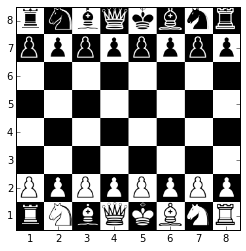

In [103]:
plt.imshow(draw_board(im), cmap = cm.Greys_r,
          extent=[0.5,8.5,0.5,8.5])

In [34]:
def piece_prob_matrix(im, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    if clipping:
        print "Probability matrix without clipping"
    else:
        print "Probability matrix before clipping"
        probs = clip_pieces_single_2(probs, im[0:12])
    matrix = probs.reshape((8,8))
    matrixplot(matrix)
def move_prob_matrix(im, piece_coords, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    probs = probs.flatten()
    #probs = clip_pieces_single_2(probs, im[0:12])
    cumulative_probs = np.zeros((64,64))    
    for i, piece_pos in enumerate(topk(probs,10)):
        if probs[piece_pos]>0:
            i1,i2 = scoreToCoordinateIndex(piece_pos)
            pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
            piece_layer = np.zeros((1,8,8))
            piece_layer[0,i1,i2] = 1
            img2 = np.append(im, piece_layer, axis=0)
            model = trained_models[pieceType]
            model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
            res2 = model.forward()
            move_prob = res2['prob']
            #print move_prob
            if clipping:
                move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
            #print move_prob
            cumulative_probs[piece_pos] = move_prob*probs[piece_pos]
    if clipping:
        print "Probability matrix after clipping"
    else:
        print "Probability matrix without clipping"
    matrixplot(cumulative_probs[piece_coords[0]*8+piece_coords[1]].reshape((8,8)))

In [16]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image_2(bb)
    im = np.rollaxis(im,2,0)
    im = np.append(im, elo_layer, axis=0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r, extent=[0.5,8.5,0.5,8.5])
    plt.show()

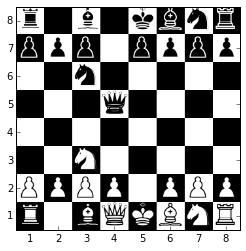

Probability matrix before clipping


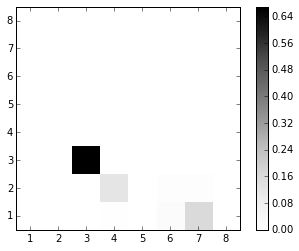

Probability matrix without clipping


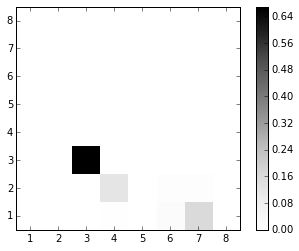

Probability matrix without clipping


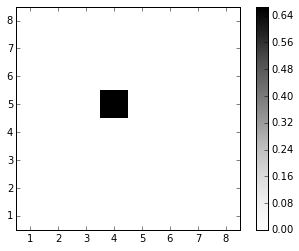

Probability matrix after clipping


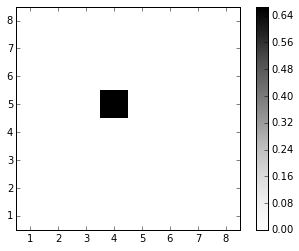

In [35]:
fen = 'r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,2), False)
move_prob_matrix(im, (5,2))

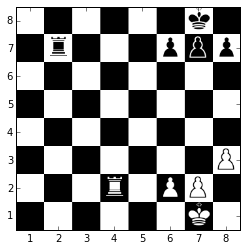

Probability matrix before clipping


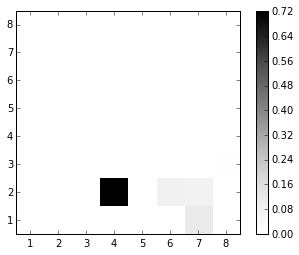

Probability matrix without clipping


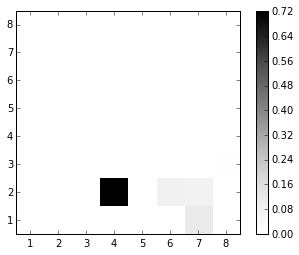

Probability matrix without clipping


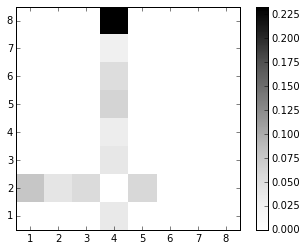

Probability matrix after clipping


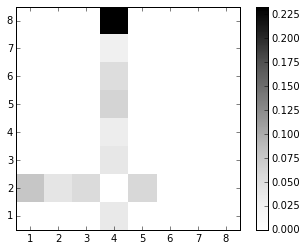

In [23]:
fen = '6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3), False)
move_prob_matrix(im, (6,3))

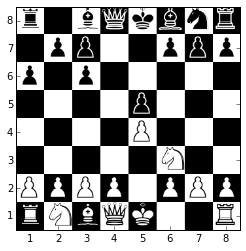

Probability matrix before clipping


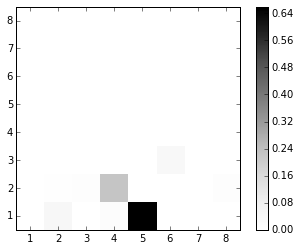

Probability matrix without clipping


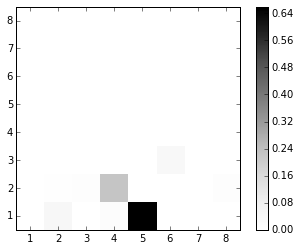

Probability matrix without clipping


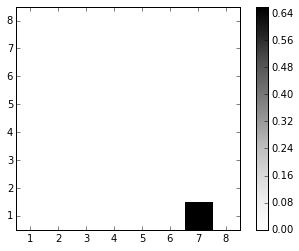

Probability matrix after clipping


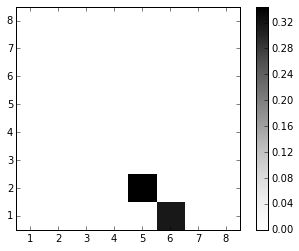

In [24]:
fen = 'r1bqkbnr/1pp2ppp/p1p5/4p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,4), False)
move_prob_matrix(im, (7,4))

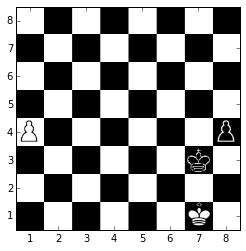

Probability matrix before clipping


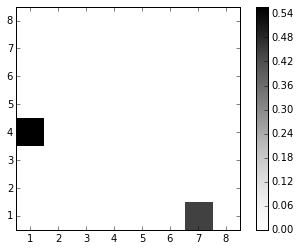

Probability matrix without clipping


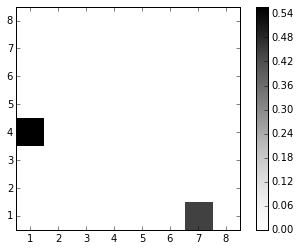

Probability matrix without clipping


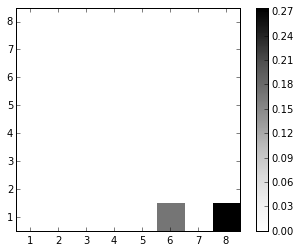

Probability matrix after clipping


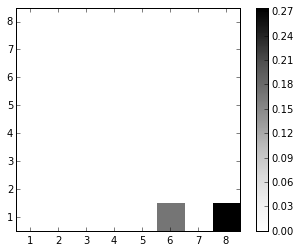

In [25]:
fen = '8/8/8/8/P6p/6k1/8/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,6), False)
move_prob_matrix(im, (7,6))

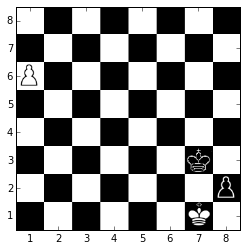

Probability matrix before clipping


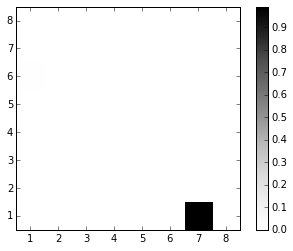

Probability matrix without clipping


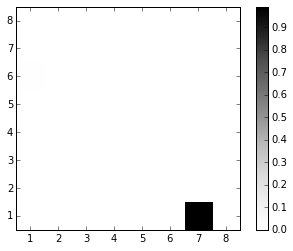

Probability matrix without clipping


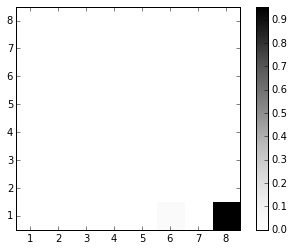

Probability matrix after clipping


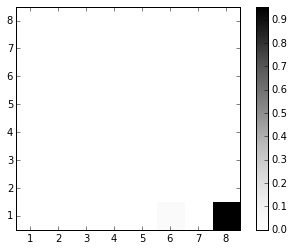

In [26]:
'''
Detecting a check and blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,6), False)
move_prob_matrix(im, (7,6))

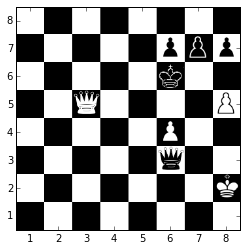

Probability matrix before clipping


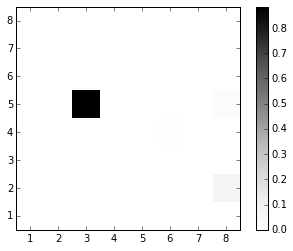

Probability matrix without clipping


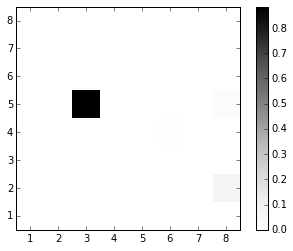

Probability matrix without clipping


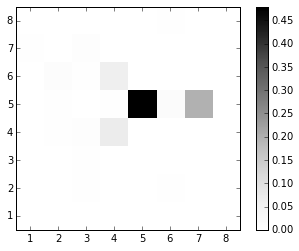

Probability matrix after clipping


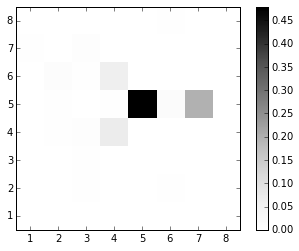

In [27]:
'''
Mate in 1
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (3,2), False)
move_prob_matrix(im, (3,2))

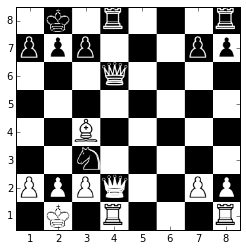

Probability matrix before clipping


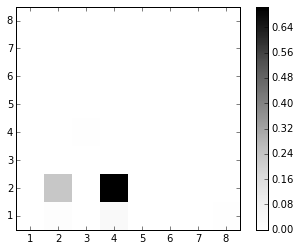

Probability matrix without clipping


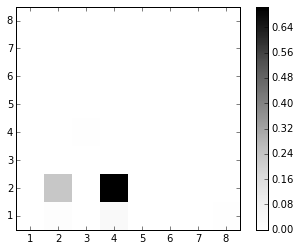

Probability matrix without clipping


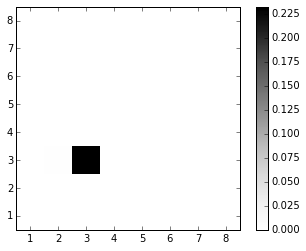

Probability matrix after clipping


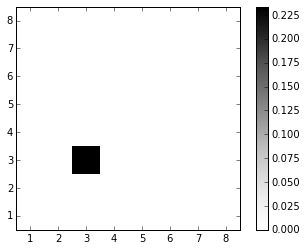

"\nA huge shock! \nBlack's knight is attacking my king and my rook on e8 - this is called a FORK (more on this later). \nAlso my queen on e7 is under attack twice (from White's queen and e1-rook). \nAlso, my back rank is weak! \nIf I capture the knight with my queen, White can play Qxe8 Rxe8 Rxe8 checkmate! \nAnd if I capture the knight with my pawn, he can play Qxe7 Rxe7 Rxe7. \nSo my only choice is to play...\n"

In [28]:
'''
Check
'''
fen='1k1r3r/ppp3pp/3q4/8/2B5/2n5/PPPQ2PP/1K1R3R w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,1), False)
move_prob_matrix(im, (6,1))
'''
A huge shock! 
Black's knight is attacking my king and my rook on e8 - this is called a FORK (more on this later). 
Also my queen on e7 is under attack twice (from White's queen and e1-rook). 
Also, my back rank is weak! 
If I capture the knight with my queen, White can play Qxe8 Rxe8 Rxe8 checkmate! 
And if I capture the knight with my pawn, he can play Qxe7 Rxe7 Rxe7. 
So my only choice is to play...
'''


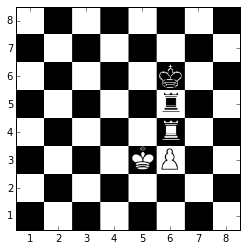

Probability matrix before clipping


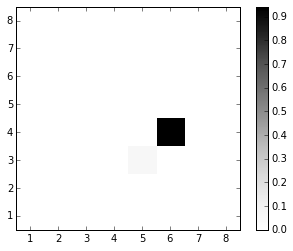

Probability matrix without clipping


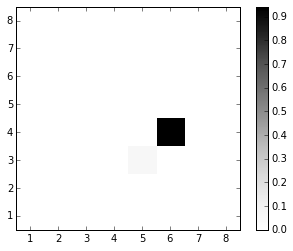

Probability matrix after clipping


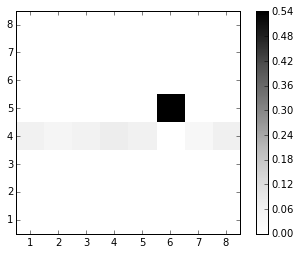

Probability matrix after clipping


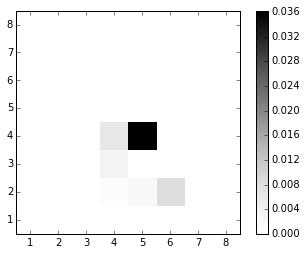

In [29]:
'''
Trading rooks for endgame
White wants to trade rooks, but only on his terms!
'''
fen = '8/8/5k2/5r2/5R2/4KP2/8/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,5))
move_prob_matrix(im, (5,4))

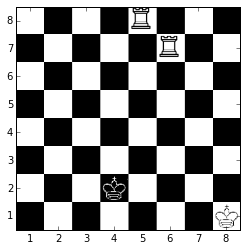

Probability matrix before clipping


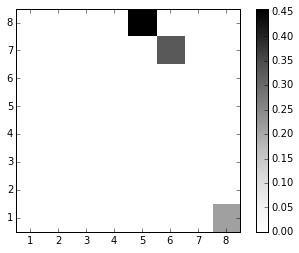

Probability matrix without clipping


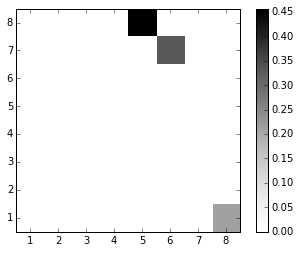

Probability matrix after clipping


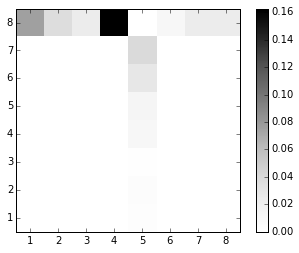

Probability matrix after clipping


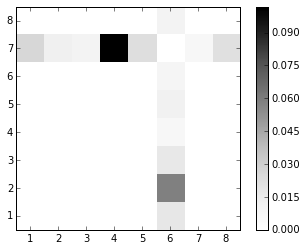

In [30]:
'''
Pushing the broom
'''
fen='4R3/5R2/8/8/8/8/3k4/7K w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (0,4))
move_prob_matrix(im, (1,5))

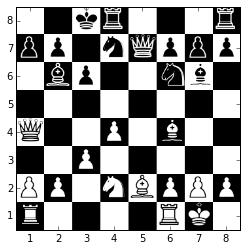

Probability matrix before clipping


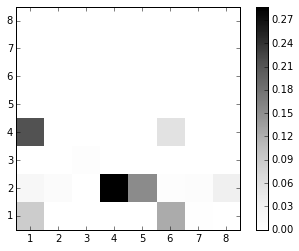

Probability matrix without clipping


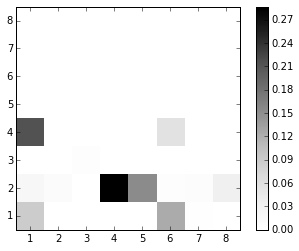

Probability matrix after clipping


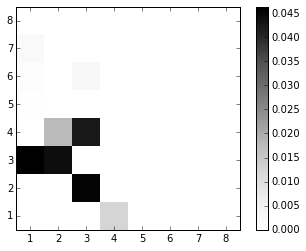

Probability matrix after clipping


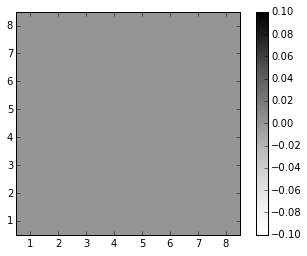

In [31]:
fen='2kr3r/pp1nqppp/1bp2nb1/8/Q2P1B2/2P5/PP1NBPPP/R4RK1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,0))
move_prob_matrix(im, (1,5))

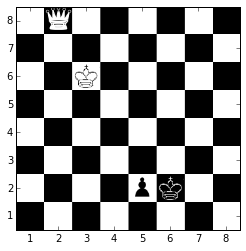

Probability matrix before clipping


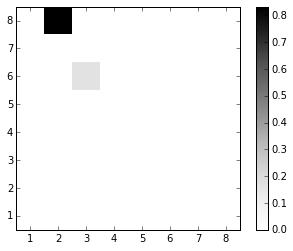

Probability matrix without clipping


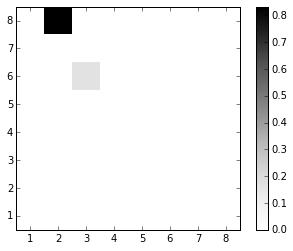

Probability matrix after clipping


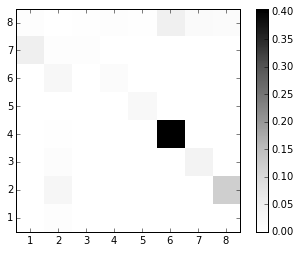

Probability matrix after clipping


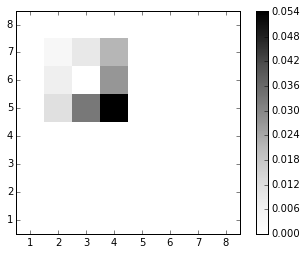

In [29]:
'''
Queen King vs King Pawn
'''
fen = '1Q6/8/2K5/8/8/8/4pk2/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (0,1))
move_prob_matrix(im, (2,2))
'''
Qf4+ gets the Queen close to the enemy King and 
stops the Black pawn from Queening but giving a check.
'''

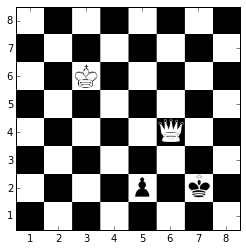

Probability matrix before clipping


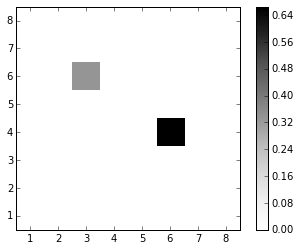

Probability matrix without clipping


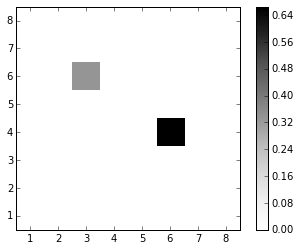

Probability matrix after clipping


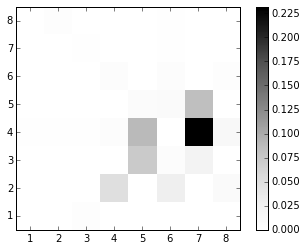

Probability matrix after clipping


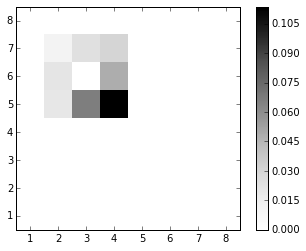

In [33]:
'''
Continued from above
'''
fen = '8/8/2K5/8/5Q2/8/4p1k1/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,5))
move_prob_matrix(im, (2,2))

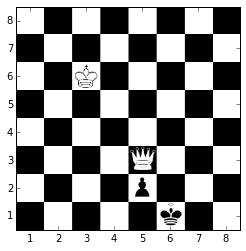

Probability matrix before clipping


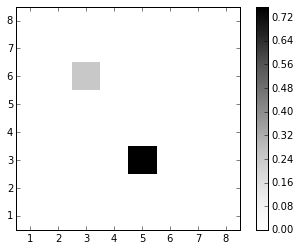

Probability matrix without clipping


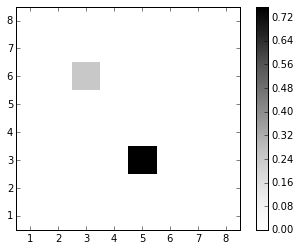

Probability matrix after clipping


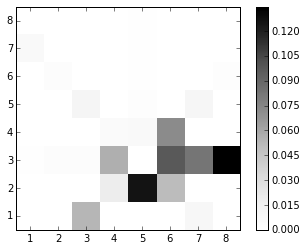

Probability matrix after clipping


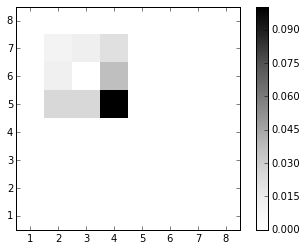

In [35]:
fen='8/8/2K5/8/8/4Q3/4p3/5k2 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,4))
move_prob_matrix(im, (2,2))

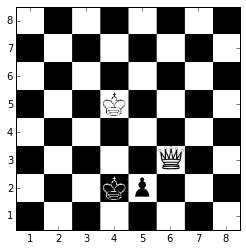

Probability matrix before clipping


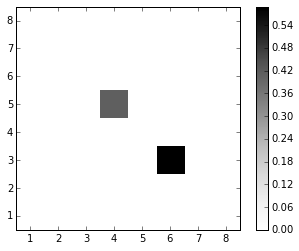

Probability matrix without clipping


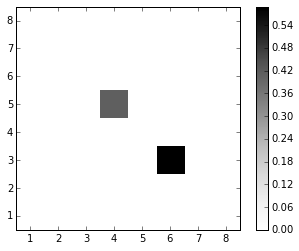

Probability matrix after clipping


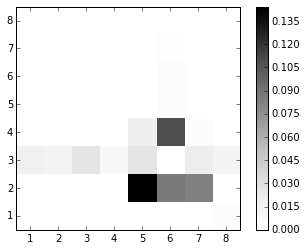

Probability matrix after clipping


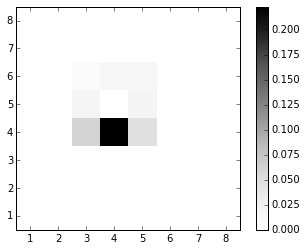

In [39]:
fen='8/8/8/3K4/8/5Q2/3kp3/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,5))
move_prob_matrix(im, (3,3))

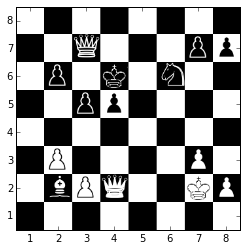

Probability matrix before clipping


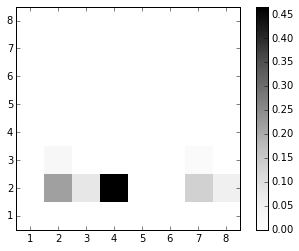

Probability matrix without clipping


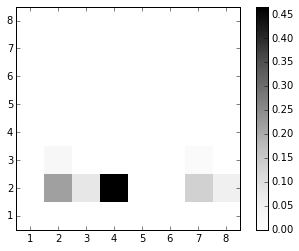

Probability matrix after clipping


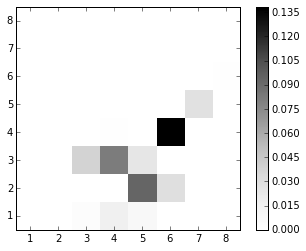

Probability matrix after clipping


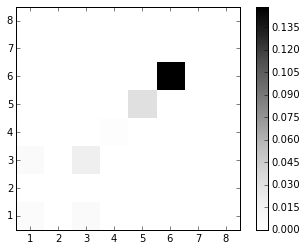

In [61]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3))
move_prob_matrix(im, (6,1))

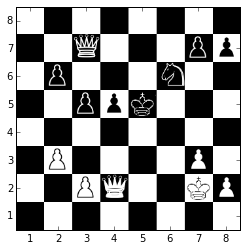

Probability matrix before clipping


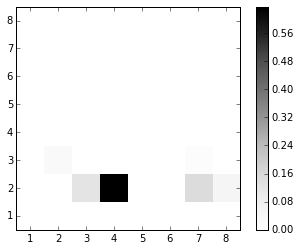

Probability matrix without clipping


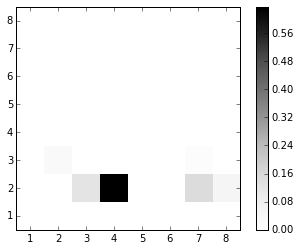

Probability matrix after clipping


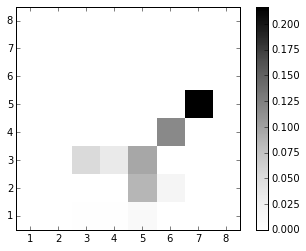

Probability matrix after clipping


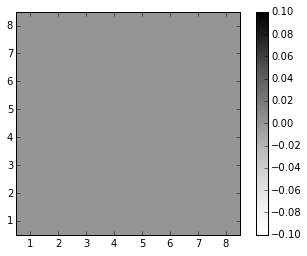

In [62]:
fen='8/2q3pp/1p3n2/2ppk3/8/1P4P1/2PQ2KP/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3))
move_prob_matrix(im, (6,1))